In [3]:
import osmnx as ox
import networkx as nx
from pyproj import CRS
from shapely.strtree import STRtree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import time

import warnings
warnings.filterwarnings("ignore")

# place_name = "Westminster, London, England"
# G = ox.graph_from_place(place_name, network_type='bike')

# custom bounding box for Central London (NSEW)
G = ox.graph_from_bbox(51.5284, 51.4176, -0.0673, -0.3080, network_type='bike')
G = ox.project_graph(G)

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

nodes, edges = ox.graph_to_gdfs(G)
projection = CRS.from_epsg(3067)
nodes = nodes.to_crs(projection)
edges = edges.to_crs(projection)

# parks = ox.geometries_from_place(place_name, {"leisure": "park"})
parks = ox.geometries_from_bbox(51.5284, 51.4176, -0.0673, -0.3080, {"leisure": "park"})
parks = parks.to_crs(projection)

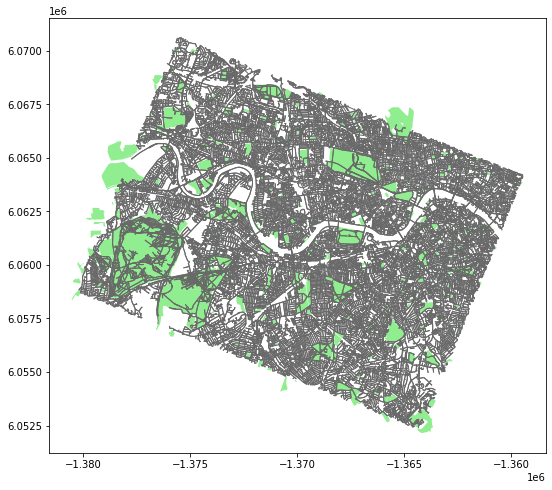

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
parks.plot(ax=ax, markersize=0, facecolor="lightgreen")
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
plt.show()

In [13]:
def add_node_elevations(G, max_locations_per_batch=200, pause_duration=0, precision=3):
    """
    Add `elevation` (meters) attribute to each node using a web service.
    This uses the Open Elevation API.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    max_locations_per_batch : int
        max number of coordinate pairs to submit in each API call (if this is
        too high, the server will reject the request because its character
        limit exceeds the max allowed)
    pause_duration : float
        time to pause between API calls, which can be increased if you get
        rate limited
    precision : int
        decimal precision to round elevation values
    Returns
    -------
    G : networkx.MultiDiGraph
        graph with node elevation attributes
    """

    url_template = "https://api.open-elevation.com/api/v1/lookup?locations={}"

    # make a pandas series of all the nodes' coordinates as 'lat,lng'
    # round coordinates to 5 decimal places (approx 1 meter) to be able to fit
    # in more locations per API call
    node_points = pd.Series(
        {node: f'{data["y"]:.5f},{data["x"]:.5f}' for node, data in G.nodes(data=True)}
    )
    n_calls = int(np.ceil(len(node_points) / max_locations_per_batch))
    ox.utils.log(f"Requesting node elevations from the API in {n_calls} calls")

    # break the series of coordinates into chunks of size max_locations_per_batch
    # API format is locations=lat,lng|lat,lng|lat,lng|lat,lng...
    results = []
    for i in range(0, len(node_points), max_locations_per_batch):
        print(f"Fetching chunk {i/max_locations_per_batch:.0f} of {len(node_points)/max_locations_per_batch:.0f}....")
        chunk = node_points.iloc[i : i + max_locations_per_batch]

        locations = "|".join(chunk)
        url = url_template.format(locations)

        # check if this request is already in the cache (if global use_cache=True)
        cached_response_json = ox.downloader._retrieve_from_cache(url)
        if cached_response_json is not None:
            response_json = cached_response_json
        else:
            try:
                # request the elevations from the API
                time.sleep(pause_duration)

                response = requests.get(url)
                response_json = response.json()
                ox.downloader._save_to_cache(url, response_json, response.status_code)

                # append these elevation results to the list of all results
                results.extend(response_json["results"])

            except Exception as e:
                print(e)
                print(f"Server responded with {response.status_code}: {response.reason}")
                i = i - max_locations_per_batch


    # sanity check that all our vectors have the same number of elements
    if not (len(results) == len(G) == len(node_points)):
        raise Exception(
            f"Graph has {len(G)} nodes but we received {len(results)} results from elevation API"
        )
    else:
        print(f"Graph has {len(G)} nodes and we received {len(results)} results from elevation API")

    # add elevation as an attribute to the nodes
    df = pd.DataFrame(node_points, columns=["node_points"])
    df["elevation"] = [result["elevation"] for result in results]
    df["elevation"] = df["elevation"].round(precision)

    nx.set_node_attributes(G, name="elevation", values=df["elevation"].to_dict())
    ox.utils.log("Added elevation data from web service to all nodes.")

    return G

# fill in missing speeds
# edges["highway"] = edges["highway"].astype(str)
# edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)
# hwy_speeds = {"residential": 30, "secondary": 30} #10, 15, 18 mph
# G = ox.add_edge_speeds(G, hwy_speeds)
# G = ox.add_edge_travel_times(G)

G = add_node_elevations(G, max_locations_per_batch=150, pause_duration=1)
G = ox.elevation.add_edge_grades(G)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.get_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], 0).dropna()


Fetching chunk 0.00 of 358....
Expecting value: line 1 column 1 (char 0)
Server responded with 504: Gateway Time-out
Fetching chunk 1.00 of 358....
Expecting value: line 1 column 1 (char 0)
Server responded with 504: Gateway Time-out
Fetching chunk 2.00 of 358....


KeyboardInterrupt: 

In [14]:
def near_feature(pt, features, nodes=nodes):
    tree = STRtree([feature for feature in features.geometry])
    near = tree.nearest(nodes.loc[pt].geometry)
    return features[features.geometry == near]

def impedance(length, grade):
    penalty = grade**2
    return length*penalty

# calculate nearest park to each node
for osmid, data in G.nodes(data=True):
    data["nearest_park"] = near_feature(osmid, parks).index.get_level_values(1)[0]

nodes = ox.graph_to_gdfs(G, edges=False)
nodes = nodes.to_crs(projection)


In [15]:
def greenness(start, end):
    p1 = parks.xs(nodes.loc[start]['nearest_park'], level=1, drop_level=False)
    p2 = parks.xs(nodes.loc[start]['nearest_park'], level=1, drop_level=False)
    d1 = nodes.loc[start].geometry.distance(p1.geometry[0])
    d2 = nodes.loc[end].geometry.distance(p2.geometry[0])

    a = 100 # zero-threshold - max 710.4/b
    b = 0.15
    if d1 > a and d2 > a: return 1
    elif d1 > a: return 1 - 1 / np.cosh(b*d2)
    elif d2 > a: return 1 - 1 / np.cosh(b*d1)
    else: return 1 - 1 / (np.cosh(b*d1) + np.cosh(b*d2))

for source, sink, _, data in G.edges(keys=True, data=True):
    # data["impedance"] = impedance(data["length"], data["grade"])
    # data["ascent"] = max(0,data["length"]*data["grade"])
    data["greenness"] = greenness(source, sink)

edges = ox.graph_to_gdfs(G, nodes=False)
edges = edges.to_crs(projection)

nx.get_edge_attributes(G, 'greenness')

{(78112, 25508583, 0): 0.7591423833103443,
 (78112, 25508584, 0): 0.765317565046145,
 (78112, 25508584, 1): 0.765317565046145,
 (25508583, 103928, 0): 0.7591208110615026,
 (25508583, 78112, 0): 0.7591423833103443,
 (25508584, 78112, 0): 0.765317565046145,
 (25508584, 4595403137, 0): 0.7749047495572483,
 (99936, 2146383892, 0): 0.9998504311407654,
 (99936, 2146383887, 0): 0.9998545571792571,
 (99936, 4544836433, 0): 0.9997090084497284,
 (2146383892, 99936, 0): 0.9998504311407654,
 (2146383887, 99936, 0): 0.9998538372267555,
 (2146383887, 2146383897, 0): 0.9996774508026147,
 (4544836433, 197699, 0): 0.8239750171334237,
 (4544836433, 6312024921, 0): 0.7959180745618639,
 (4544836433, 2824526464, 0): 0.7336958350690093,
 (4544836433, 2146383887, 0): 0.9997096853490892,
 (99937, 200047, 0): 1,
 (99937, 1137916959, 0): 1,
 (200047, 2146383897, 0): 1,
 (200047, 99936, 0): 0.9997327193097354,
 (1137916959, 25470798, 0): 1,
 (1137916959, 1137916938, 0): 1,
 (101982, 1611082208, 0): 0.53065232358

0.9801903250824132 0.9117487964617272
Short route takes 5 minutes and has greenness score 0.9802.
Green route takes 11 minutes and has greenness score 0.9117.


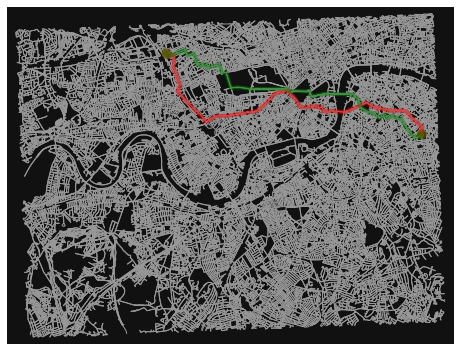

<Figure size 432x288 with 0 Axes>

In [18]:
orig = list(G)[np.random.randint(len(list(G)))]
dest = list(G)[np.random.randint(len(list(G)))]

short = ox.shortest_path(G, orig, dest, weight='travel_time')
green = ox.shortest_path(G, orig, dest, weight='greenness')

short_green = (np.mean(ox.utils_graph.get_route_edge_attributes(G, short, "greenness")))
short_time = (np.mean(ox.utils_graph.get_route_edge_attributes(G, short, "travel_time")))
green_green = (np.mean(ox.utils_graph.get_route_edge_attributes(G, green, "greenness")))
green_time = (np.mean(ox.utils_graph.get_route_edge_attributes(G, green, "travel_time")))
print(f"Short route takes {short_time:.0f} minutes and has greenness score {short_green:.4f}.")
print(f"Green route takes {green_time:.0f} minutes and has greenness score {green_green:.4f}.")


fig, ax = ox.plot_graph_routes(G, routes=[short, green], route_colors=['r','g'], node_size=0)
plt.show()

In [19]:
# # save graph to disk
ox.save_graphml(G, './data/London.graphml')

# # load graph from disk and confirm 'w3' edge attribute is there
# G2 = ox.load_graphml('./data/Westminster.graphml')
# nx.get_edge_attributes(G2, 'speed_kph')